In [2]:
import pandas as pd
import os

import pickle

import matplotlib.pyplot as plt
import seaborn as sns

import random

import numpy as np 

import pybedtools
sns.set(color_codes=True) # Seaborn desaturates matplotlib colors (this is useful if you use both seaborn and basic matplot lib and want colors to be consistent)
sns.set(palette='husl', context = 'poster', style='white', color_codes=True)

In [10]:
BASE_PATH = "/".join(os.getcwd().split("/")) # base directory level

BIN_PATH = os.path.join(BASE_PATH, "bin")  # where my scripts live
DATA_PATH = os.path.join(BASE_PATH, "data")  # where I dump new data.
RESULTS_PATH = os.path.join(BASE_PATH, "results")  # where I analyze results

SRC_PATH = os.path.join(BASE_PATH, "src")  # where any packages needed to run analyses live. I haven't started structuring things this way yet. 

COMP_PATH = os.path.join(DATA_PATH,"pairwise")

# Functions

In [4]:
def get_metric(row, metric):
    i = row.name
    if metric == 'mse':
        m = comp_dict[i].set_index(['chr','windowStartPos']).mse
    if metric == 'spearman':
        m = comp_dict[i].set_index(['chr','windowStartPos']).spearman
    if metric == 'divergence':
        m = 1 - comp_dict[i].set_index(['chr','windowStartPos']).spearman
    row[2:] = m
    return row

In [5]:
def calc_one_pop_stats(pop, within_comps, between_comps):
    
    tmp = pd.DataFrame(index=['within','between','all'], columns = comp_list_div.columns[2:])
    tmp.loc['within'] = comp_list_div.loc[within_comps].mean()
    tmp.loc['between'] = comp_list_div.loc[between_comps].mean()
    tmp.loc['all'] = comp_list_div.loc[all_comps].mean()
    tmp.loc['nonAFR'] = comp_list_div.loc[nonAFR].mean()
    # (between - within)/between
    tmp.loc['old_fst'] = (tmp.loc['between'] - tmp.loc['within']) / tmp.loc['between']
    # (all - within)/all
    tmp.loc['new_fst'] = (tmp.loc['all'] - tmp.loc['within']) / tmp.loc['all']
    #tmp.loc['new_difference'] = (tmp.loc['between'] - tmp.loc['within'])
    if pop != 'AFR':
        tmp.loc['new_fst_nonAFR'] = (tmp.loc['nonAFR'] - tmp.loc['within']) / tmp.loc['nonAFR']
    return tmp.T

In [6]:
def plot_pop_diff(pop):
    plt.figure(figsize=(10,5))
    plt.hist(pop.new_fst, color = sns.husl_palette(10)[0], bins=50)
    m = round(pop.new_fst.astype('float').describe()['mean'],2)
    sd = round(pop.new_fst.astype('float').describe()['std'],2)
    plt.title("3D Differentiation (All): mean: %s, sd: %s" % (m, sd))
    plt.show()

    plt.figure(figsize=(10,5))
    plt.hist(pop.new_fst_nonAFR, color = sns.husl_palette(10)[3], bins=50)
    m = round(pop.new_fst_nonAFR.astype('float').describe()['mean'],2)
    sd = round(pop.new_fst_nonAFR.astype('float').describe()['std'],2)
    plt.title("3D Differentiation (nonAFR): mean: %s, sd: %s" % (m, sd))
    plt.show()


    plt.figure(figsize=(15,5))
    sns.lineplot(y = pop.loc['chr22'].new_fst, x=pop.loc['chr22'].index, color = sns.husl_palette(10)[0], label='3D Fst (All)')
    sns.lineplot(y = pop.loc['chr22'].new_fst_nonAFR, x=pop.loc['chr22'].index, color = sns.husl_palette(10)[3], label='3D Fst (nonAFR)')
    plt.legend(loc='upper right', bbox_to_anchor=(1, .5, .5, .5))

# One Time processing

## metadata

In [7]:
list_path = os.path.join(DATA_PATH, "reference/lists/listOfPairwiseComps_random5females.txt")
comp_list = pd.read_table(list_path, sep = ' ', names = ['ind1','ind2'])
meta = pd.read_table(list_path, sep = ' |_', names = ['super1','sub1','sex1','ind1','super2','sub2','sex2','ind2'])

/wynton/home/capra/egilbertson/envs/akita/lib64/python3.6/site-packages/pandas/io/parsers.py:767: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return read_csv(**locals())


## pickle dict

In [8]:
# comp_dict = {}
# for row in comp_list.index:
#     ind1 = comp_list.iloc[row].ind1
#     ind2 = comp_list.iloc[row].ind2
#     filename = '%s/subsample/3dcomp_%s_vs_%s.txt' % (COMP_PATH, ind1, ind2)
#     df = pd.read_table(filename)
#     df = df[df.chr != 'chrX']
    
#     comp_dict[row] = df
# pickle.dump( comp_dict, open( "pairwise_subsample.p", "wb" ) )    


## genome average data structure

In [9]:
#comp_dict = pickle.load( open( "pairwise_subsample.p", "rb" ) )

# comp_list['avg_mse'] = 0
# comp_list['avg_spearman'] = 0

# for comp in comp_dict.keys():
#     comp_list.loc[comp,'avg_mse'] = comp_dict[comp].mean()['mse']
#     comp_list.loc[comp,'avg_spearman']  = comp_dict[comp].mean()['spearman']
#     comp_list.loc[comp,'avg_divergence'] = (1 - comp_dict[comp]['spearman']).mean()
# comp_list = pd.concat([comp_list, meta], axis=1)

#comp_list.to_csv('/wynton/group/capra/projects/modern_human_3Dgenome/results/comp_tables/pairwise_subsample_genomewide_averages.csv')

## All comps all regions 

In [10]:
# a = comp_dict[0].set_index(['chr','windowStartPos']).index
# a = list(a)
# b = [('comparison','ind1'),('comparison','ind2')] + a
# a = pd.MultiIndex.from_tuples(b)

# comp_list_mse = pd.DataFrame(columns = a, index = comp_list.index)
# comp_list_mse['comparison'] = comp_list[['ind1','ind2']]
# comp_list_mse = comp_list_mse.apply(lambda row: get_mse(row, 'mse'),axis=1)

# comp_list_spear = pd.DataFrame(columns = a, index = comp_list.index)
# comp_list_spear['comparison'] = comp_list[['ind1','ind2']]
# comp_list_spear = comp_list_spear.apply(lambda row: get_metric(row, 'spearman'),axis=1)

# comp_list_div = pd.DataFrame(columns = a, index = comp_list.index)
# comp_list_div['comparison'] = comp_list[['ind1','ind2']]
# comp_list_div = comp_list_div.apply(lambda row: get_metric(row, 'divergence'),axis=1)

# comp_list_mse.to_csv('/wynton/group/capra/projects/modern_human_3Dgenome/results/comp_tables/pairwise_subsample_mse_per_region.csv')
# comp_list_spear.to_csv('/wynton/group/capra/projects/modern_human_3Dgenome/results/comp_tables/pairwise_subsample_spearman_per_region.csv')
# comp_list_div.to_csv('/wynton/group/capra/projects/modern_human_3Dgenome/results/comp_tables/pairwise_subsample_divergence_per_region.csv')

# Read in data

In [11]:
DATA_PATH

'/wynton/group/capra/projects/modern_human_3Dgenome/data'

In [12]:
comp_dict = pickle.load( open( "%s/intermediates/pairwise_subsample.p" % DATA_PATH, "rb" ) )
comp_dict

{0:         chr  windowStartPos       mse  spearman
 0      chr1         1048576  0.001869  0.997084
 1      chr1         1572864  0.000937  0.997358
 2      chr1         3145728  0.002293  0.995971
 3      chr1         3670016  0.000540  0.992598
 4      chr1         4194304  0.000364  0.989864
 ...     ...             ...       ...       ...
 4868  chr22        46661632  0.000390  0.995073
 4869  chr22        47185920  0.000098  0.993318
 4870  chr22        47710208  0.000513  0.990157
 4871  chr22        48234496  0.001140  0.979008
 4872  chr22        48758784  0.000406  0.994997
 
 [4873 rows x 4 columns],
 1:         chr  windowStartPos       mse  spearman
 0      chr1         1048576  0.002008  0.996632
 1      chr1         1572864  0.000933  0.996887
 2      chr1         3145728  0.000992  0.998349
 3      chr1         3670016  0.000476  0.997376
 4      chr1         4194304  0.000147  0.996101
 ...     ...             ...       ...       ...
 4868  chr22        46661632  0.000

In [13]:
comp_list = pd.read_csv('/wynton/group/capra/projects/modern_human_3Dgenome/results/comp_tables/pairwise_subsample_genomewide_averages.csv',
                       index_col=0)
comp_list
comp_list_nonAFR = comp_list[(comp_list.super1 != 'AFR') & (comp_list.super2 != 'AFR')]

In [14]:
comp_list_mse = pd.read_csv('/wynton/group/capra/projects/modern_human_3Dgenome/results/comp_tables/pairwise_subsample_mse_per_region.csv',
                       index_col=0, header=[0,1])
comp_list_spear = pd.read_csv('/wynton/group/capra/projects/modern_human_3Dgenome/results/comp_tables/pairwise_subsample_spearman_per_region.csv',
                       index_col=0, header=[0,1])
comp_list_div = pd.read_csv('/wynton/group/capra/projects/modern_human_3Dgenome/results/comp_tables/pairwise_subsample_divergence_per_region.csv',
                       index_col=0, header=[0,1])
comp_list_mse

comparison                              chr1            \
                        ind1                    ind2   1048576   1572864   
0     AFR_ASW_female_NA19917  AFR_ASW_female_NA19901  0.001869  0.000937   
1     AFR_ASW_female_NA19917  AFR_ASW_female_NA20314  0.002008  0.000933   
2     AFR_ASW_female_NA19917  AFR_ASW_female_NA20317  0.003096  0.001978   
3     AFR_ASW_female_NA19917  AFR_ASW_female_NA19625  0.000554  0.000326   
4     AFR_ASW_female_NA19917  AFR_ACB_female_HG02337  0.002644  0.001193   
...                      ...                     ...       ...       ...   
8380  EUR_CEU_female_NA12044  EUR_CEU_female_NA06985  0.000300  0.000283   
8381  EUR_CEU_female_NA12044  EUR_CEU_female_NA12046  0.000857  0.001475   
8382  EUR_CEU_female_NA07000  EUR_CEU_female_NA06985  0.000238  0.000461   
8383  EUR_CEU_female_NA07000  EUR_CEU_female_NA12046  0.000731  0.000871   
8384  EUR_CEU_female_NA06985  EUR_CEU_female_NA12046  0.000614  0.001236   

                                                                  ...  \
       3145728   3670016   4194304   4718592   5242880   5767168  ...   
0     0.002293  0.000540  0.000364  0.000307  0.000316  0.000803  ...   
1     0.000992  0.000476  0.000147  0.000063  0.000347  0.000399  ...   
2     0.003314  0.000549  0.000346  0.000239  0.000548  0.000585  ...   
3     0.003259  0.000408  0.000619  0.000253  0.000282  0.001207  ...   
4     0.002564  0.000270  0.000147  0.000232  0.000855  0.000586  ...   
...        ...       ...       ...       ...       ...       ...  ...   
8380  0.001630  0.001555  0.000073  0.000215  0.000183  0.000233  ...   
8381  0.009445  0.002801  0.000035  0.000174  0.000260  0.000265  ...   
8382  0.002554  0.000645  0.000120  0.000152  0.000348  0.000324  ...   
8383  0.003796  0.000256  0.000127  0.000134  0.000165  0.000158  ...   
8384  0.007588  0.000501  0.000057  0.000262  0.000393  0.000276  ...   

         chr22                                                              \
      44040192  44564480  45088768  45613056  46137344  46661632  47185920   
0     0.000183  0.000466  0.000246  0.000785  0.000798  0.000390  0.000098   
1     0.000203  0.000869  0.000521  0.000654  0.000420  0.000297  0.000110   
2     0.000325  0.001895  0.000226  0.000690  0.001467  0.001053  0.000100   
3     0.000089  0.002133  0.000203  0.000594  0.000507  0.000211  0.000124   
4     0.000069  0.002806  0.000400  0.000494  0.000428  0.000361  0.000150   
...        ...       ...       ...       ...       ...       ...       ...   
8380  0.000059  0.002589  0.000359  0.000136  0.000290  0.000295  0.000027   
8381  0.000048  0.002391  0.000361  0.000101  0.000627  0.000402  0.000019   
8382  0.000038  0.000221  0.000262  0.000268  0.000338  0.000294  0.000023   
8383  0.000073  0.000515  0.000604  0.000202  0.000282  0.000335  0.000060   
8384  0.000059  0.000277  0.000583  0.000108  0.000203  0.000097  0.000044   

                                    
      47710208  48234496  48758784  
0     0.000513  0.001140  0.000406  
1     0.000127  0.000312  0.000486  
2     0.000484  0.000817  0.000682  
3     0.000378  0.000516  0.000552  
4     0.001506  0.002744  0.000482  
...        ...       ...       ...  
8380  0.004405  0.006295  0.000073  
8381  0.001181  0.002474  0.000151  
8382  0.002549  0.005476  0.000369  
8383  0.002901  0.004537  0.000186  
8384  0.009158  0.014093  0.000200  

[8385 rows x 4875 columns]

# Calculate Differentiation

In [21]:
all_comps = list(comp_list.index)
pops = ['AFR','EUR','EAS','AMR','SAS']
pops_nonAFR = ['EUR','EAS','AMR','SAS']
pops = dict.fromkeys(pops)
pops_nonAFR = dict.fromkeys(pops_nonAFR)
nonAFR = list(comp_list[(comp_list.super1 != 'AFR') & (comp_list.super2 != 'AFR')].index)

In [22]:
for super_pop in pops:
    within_comps = list(comp_list[(comp_list.super1 == super_pop) & (comp_list.super2 == super_pop)].index)
    print(len(within_comps))
    between_comps = list(comp_list[((comp_list.super1 == super_pop) & (comp_list.super2 != super_pop)) 
                  | ((comp_list.super2 == super_pop) & (comp_list.super1 != super_pop))].index)
    df = calc_one_pop_stats(super_pop, within_comps, between_comps)
    
    pops[super_pop] = df

595
300
300
190
300


In [23]:
pickle.dump(pops, open( "pops_dict.p", "wb" ) )   

# Plotting

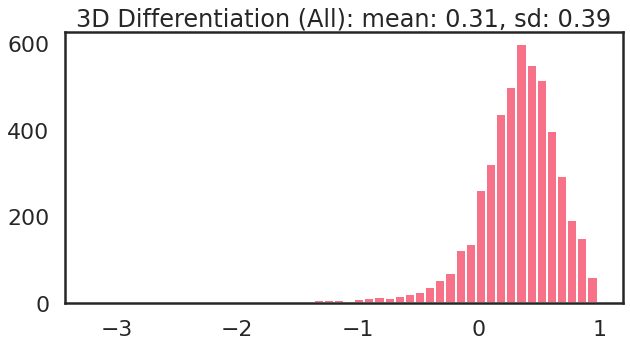

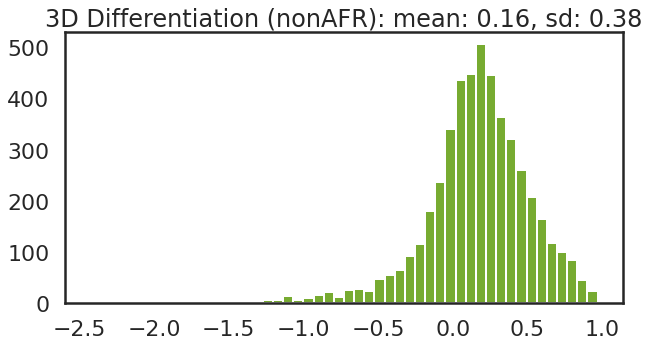

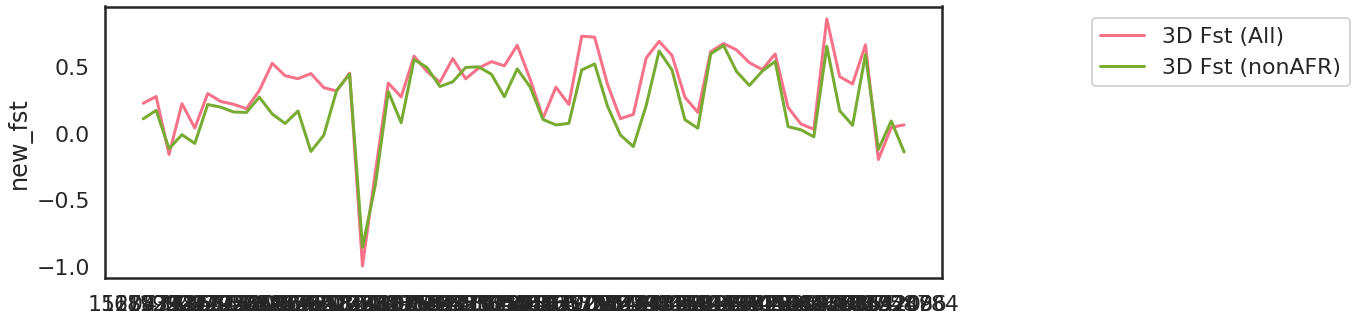

In [29]:
plot_pop_diff(pops['EAS'])

In [27]:
pops['EAS']

within     between         all      nonAFR    old_fst  \
chr1  1048576     0.0010885  0.00148062  0.00159564  0.00121995   0.264837   
      1572864   0.000957786  0.00153493  0.00170616  0.00117764   0.376005   
      3145728    0.00269242  0.00462808   0.0044166  0.00368546   0.418244   
      3670016     0.0045705  0.00524111   0.0049846  0.00478917   0.127952   
      4194304    0.00621582  0.00643891   0.0064425  0.00625151  0.0346465   
...                     ...         ...         ...         ...        ...   
chr22 46661632   0.00246652  0.00355714  0.00390967  0.00262113   0.306599   
      47185920    0.0040717  0.00941548    0.012058  0.00990182   0.567553   
      47710208    0.0189855   0.0176729   0.0158501   0.0169164 -0.0742706   
      48234496    0.0293457   0.0308953   0.0306596   0.0323043  0.0501569   
      48758784   0.00374922  0.00408719  0.00399738  0.00328309  0.0826902   

                  new_fst new_fst_nonAFR  
chr1  1048576    0.317828        0.10775  
      1572864    0.438632       0.186689  
      3145728    0.390388       0.269449  
      3670016   0.0830768      0.0456595  
      4194304   0.0351849     0.00570869  
...                   ...            ...  
chr22 46661632   0.369123      0.0589865  
      47185920   0.662324       0.588793  
      47710208   -0.19782      -0.122313  
      48234496  0.0428544      0.0915872  
      48758784  0.0620821      -0.141976  

[4873 rows x 7 columns]

Text(0.5, 0, 'Chromosome 20 position')

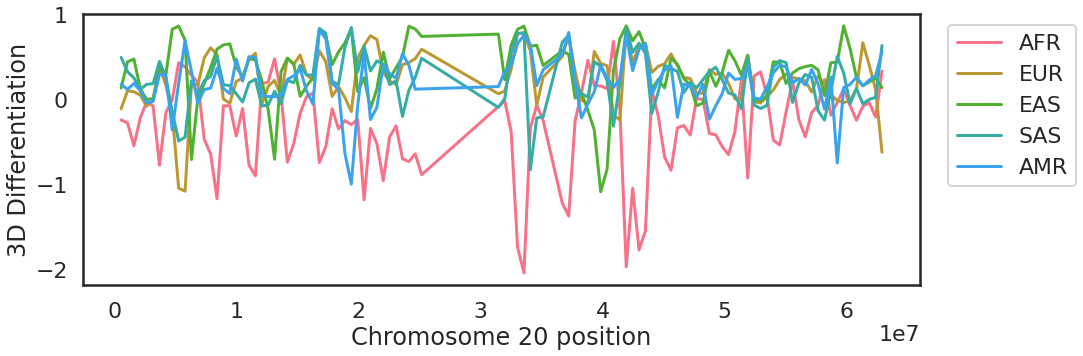

In [46]:
plt.figure(figsize=(15,5))
sns.lineplot(y = pops['AFR'].loc['chr20'].new_fst, x=pops['AFR'].loc['chr20'].index.astype(int), label='AFR')
sns.lineplot(y = pops['EUR'].loc['chr20'].new_fst, x=pops['EUR'].loc['chr20'].index.astype(int), label='EUR')
sns.lineplot(y = pops['EAS'].loc['chr20'].new_fst, x=pops['EAS'].loc['chr20'].index.astype(int), label='EAS')
sns.lineplot(y = pops['SAS'].loc['chr20'].new_fst, x=pops['SAS'].loc['chr20'].index.astype(int), label='SAS')
sns.lineplot(y = pops['AMR'].loc['chr20'].new_fst, x=pops['AMR'].loc['chr20'].index.astype(int), label='AMR')
plt.legend(loc='upper right', bbox_to_anchor=(.7, .5, .5, .5))
plt.ylabel('3D Differentiation')
plt.xlabel('Chromosome 20 position')

In [93]:
pops['EAS'].loc['chr20'].new_fst.astype(float).idxmax()

'59768832'

In [94]:
within_comps = list(comp_list[(comp_list.super1 == 'EAS') & (comp_list.super2 == 'EAS')].index)

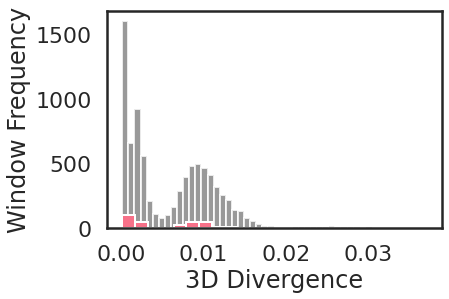

In [95]:
plt.hist(comp_list_div['chr20','2097152'], alpha=.8, color='grey', bins=50)
plt.hist(comp_list_div.loc[within_comps]['chr20','2097152'])
plt.xlabel('3D Divergence')
plt.ylabel('Window Frequency')
plt.show()

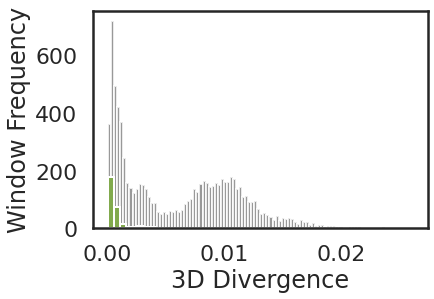

In [100]:
plt.hist(comp_list_div['chr20','59768832'], alpha=.8, color='grey', bins=100)
plt.hist(comp_list_div.loc[within_comps]['chr20','59768832'], color = (0.5061679352128585, 0.6675954483699535, 0.3024282922555064))
plt.xlabel('3D Divergence')
plt.ylabel('Window Frequency')
plt.show()

Text(0.5, 0, 'Chromosome 20 position')

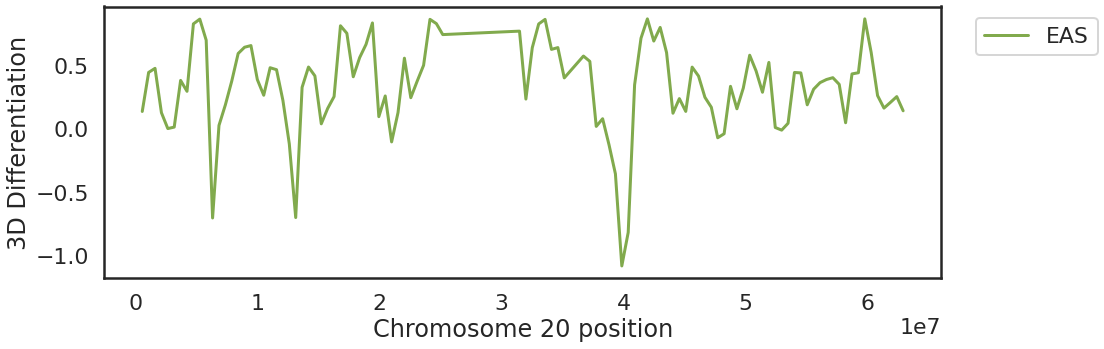

In [102]:
plt.figure(figsize=(15,5))
sns.lineplot(y = pops['EAS'].loc['chr20'].new_fst, x=pops['EAS'].loc['chr20'].index.astype(int), label='EAS', color = (0.5061679352128585, 0.6675954483699535, 0.3024282922555064))
plt.legend(loc='upper right', bbox_to_anchor=(.7, .5, .5, .5))
plt.ylabel('3D Differentiation')
plt.xlabel('Chromosome 20 position')

In [ ]:
comp

In [34]:
inds = list(comp_list_div['comparison']['ind1'].unique()) + list(comp_list_div['comparison']['ind2'].unique())
inds = set(inds)

In [37]:
inds = pd.DataFrame(inds)

In [38]:
inds.to_csv('%s/intermediates/subset_inds.csv'%DATA_PATH)